In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import os
import re
from Bio import SeqIO
from Bio import SeqUtils
import pysam
from Bio.SeqRecord import SeqRecord
from pybedtools import BedTool
import numpy as np
import pybedtools
import time
import matplotlib.pyplot as plt
import sys
import subprocess
import shutil
from Bio.Seq import Seq
import pysam
from Bio import SearchIO
import json
import glob
import scipy.stats as stats
import statsmodels as sms
import statsmodels.sandbox.stats.multicomp
import distance
import seaborn as sns
from pybedtools import BedTool
import matplotlib
from sklearn.externals.joblib import Parallel, delayed
import itertools as it
import tempfile
from scipy.signal import argrelextrema
import scipy
from IPython.display import Image
from PIL import Image

/home/benjamin/anaconda3/lib/python3.5/site-packages/Bio/SearchIO/__init__.py:211: BiopythonExperimentalWarning: Bio.SearchIO is an experimental submodule which may undergo significant changes prior to its future official release.
  BiopythonExperimentalWarning)


In [3]:
#now do some folder as input
BASEFOLDER = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp'
GENOME_FOLDER = os.path.join(BASEFOLDER, 'genomes')
OUTFOLDER = os.path.join(BASEFOLDER, 'output')
if not os.path.exists(OUTFOLDER):
    os.makedirs(OUTFOLDER)
DK0911_p = 'DK_0911_v04_p_ctg.fa'
DK0911_h = 'DK_0911_v04_h_ctg.fa'
DK0911_ph = 'DK_0911_v04_ph_ctg.fa'
PST_104E_p = 'Pst_104E_v13_p_ctg.fa'
PST_104E_h = 'Pst_104E_v13_h_ctg.fa'
PST_104E_ph = 'Pst_104E_v13_ph_ctg.fa'

In [5]:
def run_command(command):
    #print('\nRunnning now!\n')
    print(command)
    output = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
    #print("Done with it!")
    #print('\nDone\nWith ouput:\n%s' % output)
    #print(output)

In [18]:
def run_nucmer(ref, query,maxmatch=True, l=100, c=500):
    '''Run nucmer with three options.'''
    #print(os.path.basename(ref)[:-3])
    delta = os.path.join(OUTFOLDER, '%s.%s.l%s.c%s.delta' % (os.path.basename(ref)[:-3], os.path.basename(query)[:-3], l,c))
    command='/home/benjamin/anaconda3/mummer-4.0.0/bin/nucmer -l %s -c %s -t 10 %s %s --prefix=%s' % (l, c, ref, query, delta.replace('.delta', ''))
    if maxmatch == True:
        delta = os.path.join(OUTFOLDER, '%s.%s.l%s.c%s.mm.delta' % (os.path.basename(ref)[:-3], os.path.basename(query)[:-3], l,c))
        command='nucmer --maxmatch -l %s -c %s %s %s --prefix=%s' % (l, c, ref, query, delta.replace('.delta', ''))
    run_command(command)
    return delta

In [13]:
def run_delta_filter(delta, **kwargs):
    filter_string = ''
    if kwargs is not None:
        for key,value in kwargs.items():
            print('Used following delta filter option: %s %s' % (key,value))
            filter_string = '%s %s' % (filter_string, value)
    delta_filter = delta.replace('.delta', '.deltafilter_%s' %(filter_string.replace(' ', '').replace('-','')))
    command = '/home/benjamin/anaconda3/mummer-4.0.0/bin/delta-filter %s % s > %s' % (filter_string, delta, delta_filter)
    run_command(command)
    return delta_filter

In [14]:
def run_show_coords(delta_filter, **kwargs):
    filter_string = ''
    if kwargs is not None:
        for key,value in kwargs.items():
            print('Used following show-coords option: %s %s' % (key,value))
            filter_string = '%s %s' % (filter_string, value)
    #print(delta_filter.index('.delta'))
    showcoords = '%s_%s.coords' % (delta_filter[:delta_filter.index('.delta')], filter_string.replace(' ', '').replace('-',''))
    command = '/home/benjamin/anaconda3/mummer-4.0.0/bin/show-coords -T %s %s > %s' % (filter_string, delta_filter, showcoords)
    run_command(command)
    return showcoords

In [ ]:
def run_mummerplot(delta_filter, **kwargs):
    filter_string = ''
    if kwargs is not None:
        for key,value in kwargs.items():
            print('Used following mummerplot option: %s %s' % (key,value))
            filter_string = '%s %s' % (filter_string, value)
    mummerplot = os.path.basename(delta_filter) 
    previous_dir = os.getcwd()
    os.chdir(OUTFOLDER)
    command = '/home/benjamin/anaconda3/mummer-4.0.0/bin/mummerplot %s -p %s --png %s' % (filter_string, mummerplot, delta_filter)
    run_command(command)
    os.chdir(previous_dir)
    return '%s.png' % (os.path.join(OUTFOLDER, mummerplot)

In [16]:
def show_cov_plot(mummerplot, show=True):
    image = Image.open(mummerplot)
    image = image.crop((10,500,800,800))
    print('This is the coverage plot %s!' % os.path.basename(mummerplot))
    image
    return image

In [ ]:
def show_align_plot(mummerplot, show=True):
    image = Image.open(mummerplot)
    image = image.crop((10,500,800,800))
    print('This is the alignment plot %s!' % os.path.basename(mummerplot))
    image
    return image

In [ ]:
delta_DK0911_self_nmm = run_nucmer(os.path.join(GENOME_FOLDER, DK0911_p), os.path.join(GENOME_FOLDER, DK0911_h), maxmatch=False)
delta_DK0911_Pst_104Ep_nmm = run_nucmer(os.path.join(GENOME_FOLDER, DK0911_p), os.path.join(GENOME_FOLDER, PST_104E_p), maxmatch=False)
delta_DK0911_Pst_104Eph_nmm = run_nucmer(os.path.join(GENOME_FOLDER, DK0911_p), os.path.join(GENOME_FOLDER, PST_104E_ph), maxmatch=False)
delta_Pst_104E_DK0911ph_nmm = run_nucmer(os.path.join(GENOME_FOLDER, PST_104E_p), os.path.join(GENOME_FOLDER, DK0911_ph), maxmatch=False)
delta_Pst_104E_self_nmm = run_nucmer(os.path.join(GENOME_FOLDER, PST_104E_p), os.path.join(GENOME_FOLDER, PST_104E_h), maxmatch=False)
delta_Pst_104E_DK0911p_nmm = run_nucmer(os.path.join(GENOME_FOLDER, PST_104E_p), os.path.join(GENOME_FOLDER, DK0911_p), maxmatch=False)

/home/benjamin/anaconda3/mummer-4.0.0/bin/nucmer -l 100 -c 500 -t 10 /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/genomes/DK_0911_v04_p_ctg.fa /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/genomes/DK_0911_v04_h_ctg.fa --prefix=/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500
/home/benjamin/anaconda3/mummer-4.0.0/bin/nucmer -l 100 -c 500 -t 10 /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/genomes/DK_0911_v04_p_ctg.fa /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/genomes/Pst_104E_v13_p_ctg.fa --prefix=/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.Pst_104E_v13_p_ctg.

In [ ]:
delta_Pst_104Eph_DK0911ph_mm = run_nucmer(os.path.join(GENOME_FOLDER, PST_104E_ph), os.path.join(GENOME_FOLDER, DK0911_ph))
delta_DK0911ph_Pst_104Eph_mm = run_nucmer(os.path.join(GENOME_FOLDER, DK0911_ph), os.path.join(GENOME_FOLDER, PST_104E_ph))

In [ ]:
#run a couple of delta mapping for mummer
delta_DK0911_self_mm = run_nucmer(os.path.join(GENOME_FOLDER, DK0911_p), os.path.join(GENOME_FOLDER, DK0911_h))
delta_DK0911_Pst_104Ep_mm = run_nucmer(os.path.join(GENOME_FOLDER, DK0911_p), os.path.join(GENOME_FOLDER, PST_104E_p))
delta_DK0911_Pst_104Eph_mm = run_nucmer(os.path.join(GENOME_FOLDER, DK0911_p), os.path.join(GENOME_FOLDER, PST_104E_ph))

In [ ]:
delta_Pst_104E_DK0911p_mm = run_nucmer(os.path.join(GENOME_FOLDER, PST_104E_p), os.path.join(GENOME_FOLDER, DK0911_p))
delta_Pst_104E_DK0911ph_mm = run_nucmer(os.path.join(GENOME_FOLDER, PST_104E_p), os.path.join(GENOME_FOLDER, DK0911_ph))
delta_Pst_104E_self_mm = run_nucmer(os.path.join(GENOME_FOLDER, PST_104E_p), os.path.join(GENOME_FOLDER, PST_104E_h))

In [ ]:
from PIL import Image

# we get the image

image = Image.open(run_mummerplot(run_delta_filter(delta_DK0911_self_mm, **{'m':'-m'}), **{'c': '-c', 'r': '-r pcontig_000'}))

In [ ]:
image.size

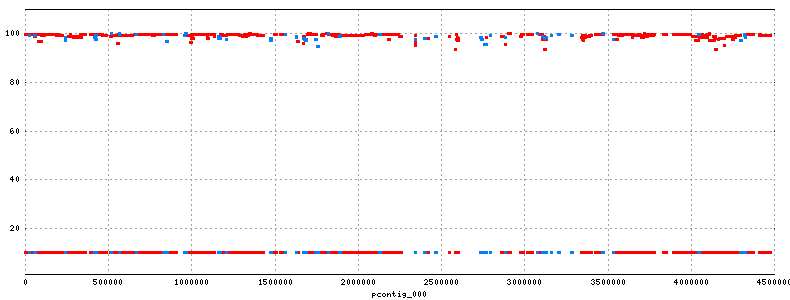

In [175]:
image.crop((10,500,800,800))

Used following delta filter option: m -m
Used following mummerplot option: c -c
Used following mummerplot option: r -r pcontig_000


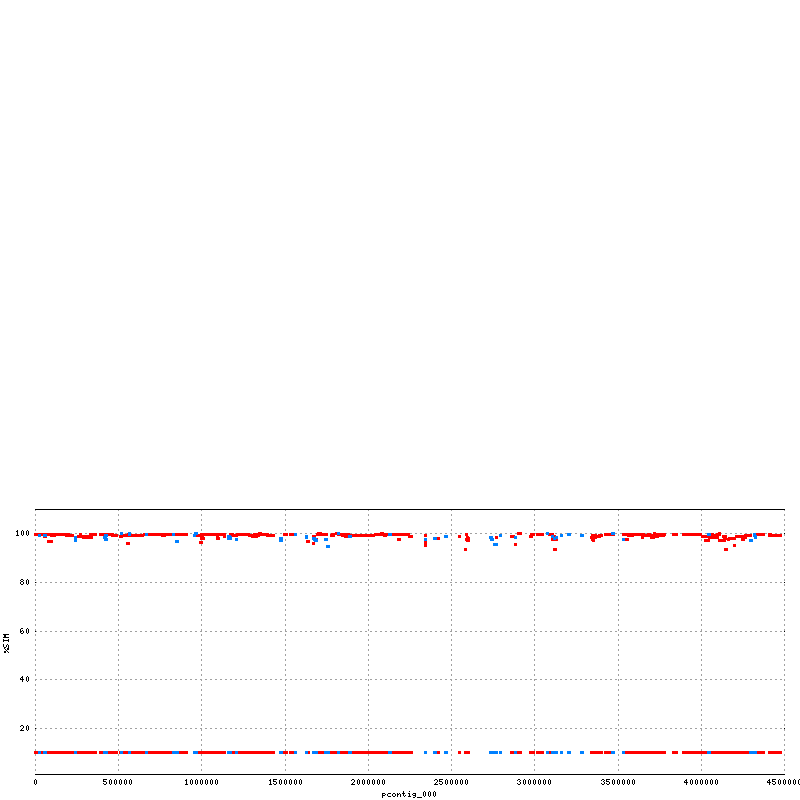

Used following mummerplot option: c -c
Used following mummerplot option: r -r pcontig_000


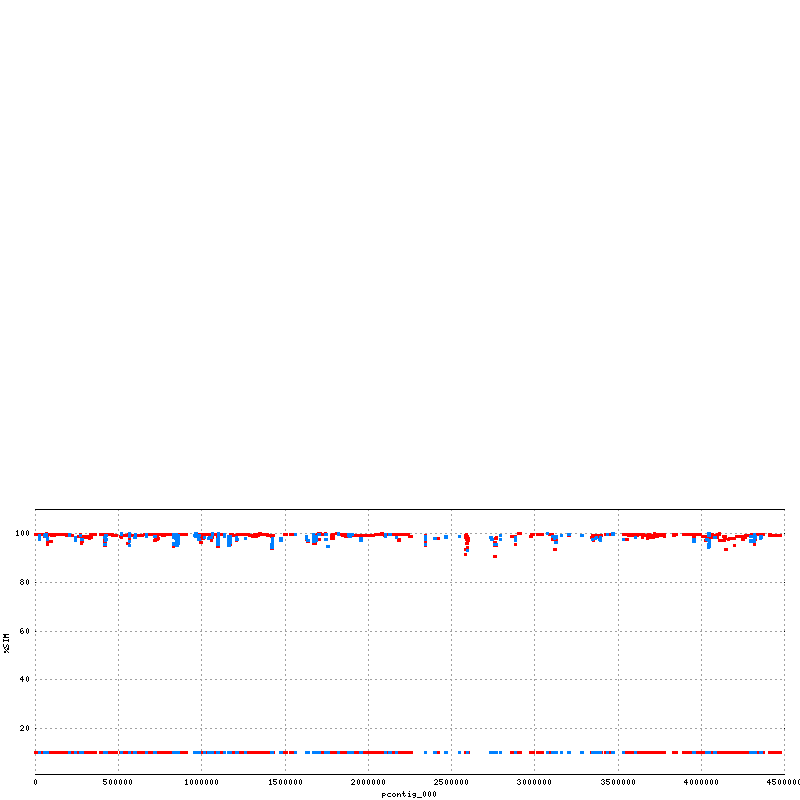

In [166]:
display(Image(run_mummerplot(run_delta_filter(delta_DK0911_self_mm, **{'m':'-m'}), **{'c': '-c', 'r': '-r pcontig_000'})))
display(Image(run_mummerplot(run_delta_filter(delta_DK0911_self_mm), **{'c': '-c', 'r': '-r pcontig_000'})))
display(Image(run_mummerplot(run_delta_filter(delta_DK0911_self_nmm), **{'c': '-c', 'r': '-r pcontig_000'})))

In [ ]:
os.


Runnning now!

delta-filter  /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.delta > /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_
Done with it!
Used following mummerplot option: c -c
Used following mummerplot option: r -r pcontig_000

Runnning now!

mummerplot  -c -r pcontig_000 -p DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_ --png /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_
Done with it!


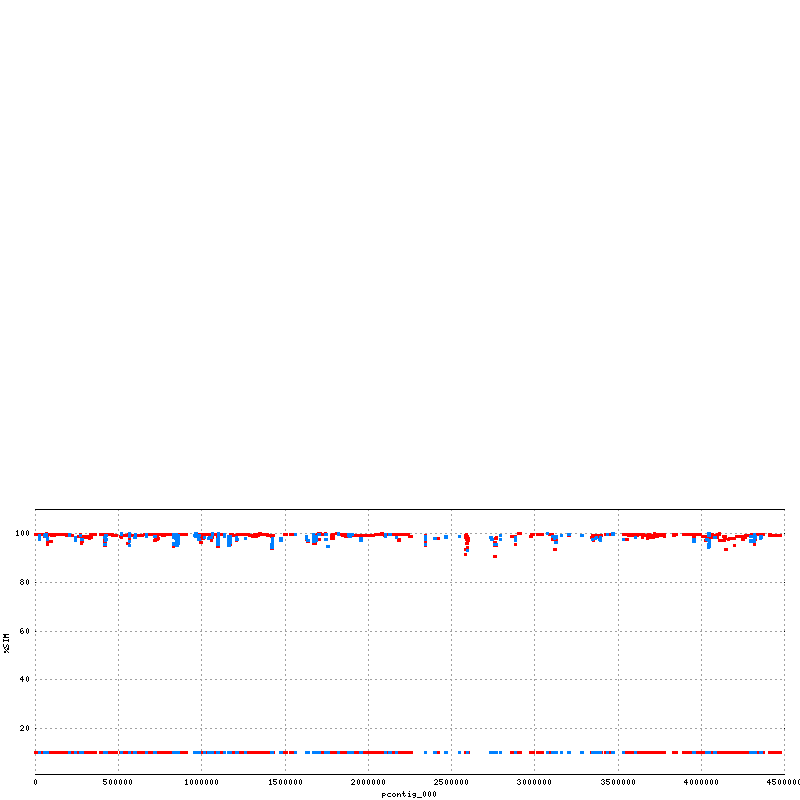

In [164]:
display(Image(run_mummerplot(run_delta_filter(delta_DK0911_self_mm), **{'c': '-c', 'r': '-r pcontig_000'})))

In [157]:
np_image = [img2array(im) for im in images]

In [160]:
np_image 

[]

In [159]:
for img in np_image:
    plt.figure()
    plt.imshow(img)

Used following delta filter option: m -m

Runnning now!

delta-filter  -m /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.delta > /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_m
Done with it!
Used following mummerplot option: c -c
Used following mummerplot option: r -r pcontig_000

Runnning now!

mummerplot  -c -r pcontig_000 -p DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_m --png /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_m
Done with it!


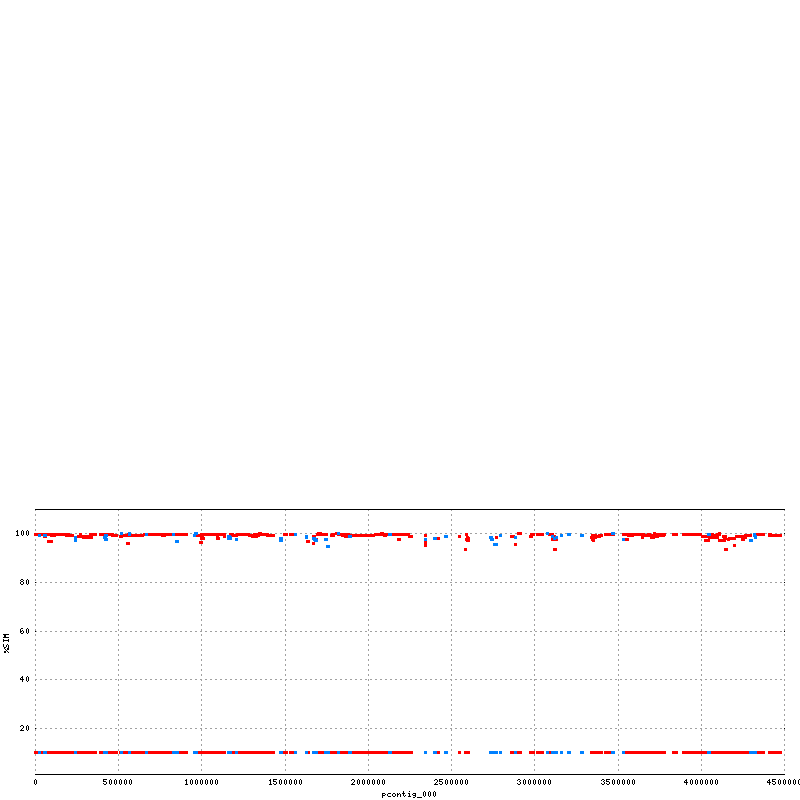

In [150]:
display(Image(run_mummerplot(run_delta_filter(delta_DK0911_self_mm, **{'m':'-m'}), **{'c': '-c', 'r': '-r pcontig_000'}), width=1000, height=300))

In [131]:
delta_filters = {'m':'-m'}
delta_filters = {}
show_coords_filter = {'l': '-l', 'r': '-r'}
mummerplot_filter = {'c': '-c', 'r': '-r pcontig_000'}

Used following delta filter option: m -m

Runnning now!

delta-filter  -m /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.delta > /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_m
Done with it!
Used following mummerplot option: c -c
Used following mummerplot option: r -r pcontig_000

Runnning now!

mummerplot  -c -r pcontig_000 -p DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_m --png /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_m
Done with it!


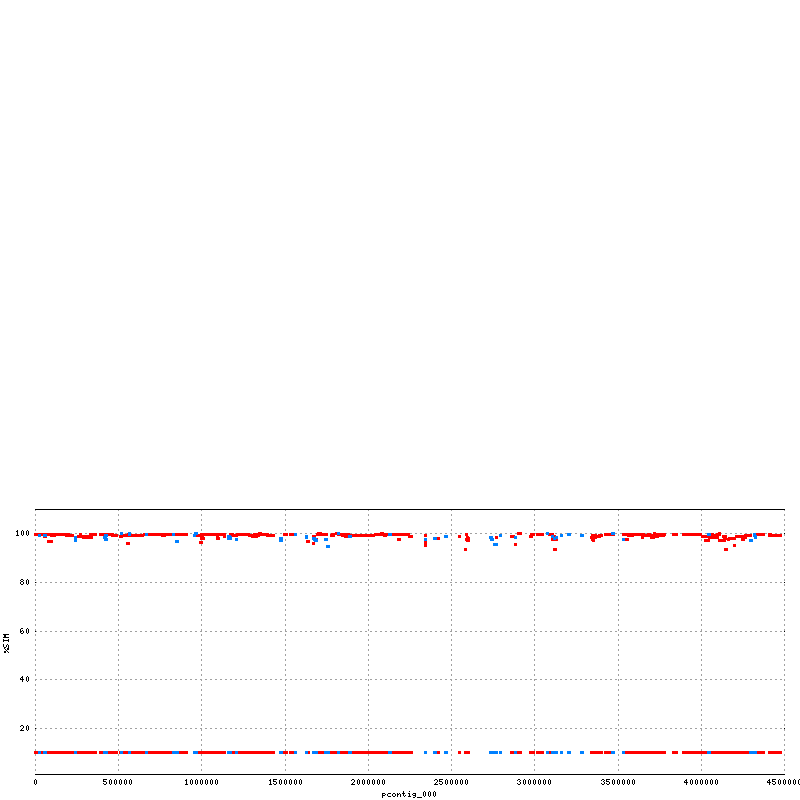

In [146]:
Image(run_mummerplot(run_delta_filter(delta_DK0911_self_mm, **{'m':'-m'}), **{'c': '-c', 'r': '-r pcontig_000'}), width=1000, height=300)

In [ ]:
Image(run_mummerplot(run_delta_filter(delta_DK0911_self_mm), **{'c': '-c', 'r': '-r pcontig_000'}))

In [120]:
showcoords = run_show_coords(delta_filter, **show_coords_filter)

Used following show-coords option: r -r
Used following show-coords option: l -l

Runnning now!

show-coords -T  -r -l /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_m > /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm_rl.coords

Done
With ouput:
b''
b''


In [133]:
mummer_plot = run_mummerplot(delta_filter, **mummerplot_filter)

Used following mummerplot option: c -c
Used following mummerplot option: r -r pcontig_000

Runnning now!

mummerplot  -c -r pcontig_000 -p DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_ --png /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_

Done
With ouput:
b'gnuplot 4.6 patchlevel 6\nReading delta file /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/Warrior_comp_runs/mummer_comp/output/DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_\nWriting plot files DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_.fplot, DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_.rplot\nWriting gnuplot script DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_.gp\nRendering plot DK_0911_v04_p_ctg.DK_0911_v04_h_ctg.l100.c500.mm.deltafilter_.png\n'
b'gnuplot 4.6 patchlevel 6\nReading delta file /h

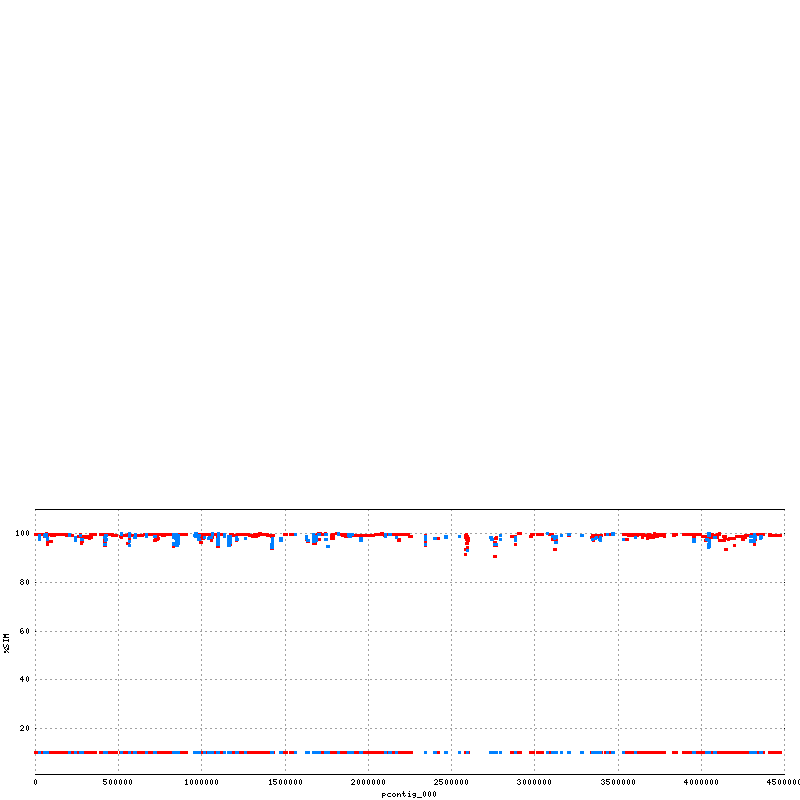

In [134]:
previous_dir = os.getcwd()
os.chdir(OUTFOLDER)
Image(mummer_plot)
#os.chdir(previous_dir)